In [33]:
import pandas as pd
import json
import csv
import os
import numpy as np
import torch

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from tqdm import tqdm

### Analysis of dataset

In [6]:
data_path="../data/Wiki_TabNER_dataset.json"

with open(data_path, 'r') as f:
    ner_tables = json.load(f)  
    
print(len(ner_tables))

62433


### Check if any tables with only O annotation

In [7]:
len(ner_tables)

62433

In [9]:
empty_tables = []
tab_ids = []
num_unique = []

for idx in range(len(ner_tables)):
  
    tab_annotation = []
    
    table = ner_tables[idx][0]
    tab_id = table[0]
    tableHeaders = table[4]
    table_data = table[5]

    row_labels = table[6]
    
    for row in row_labels:       
        for cell in row:   
            for span in cell:           
                if len(span)>0:
                    cls = span[-1]
                    if type(cls) == int:
                        tab_annotation.append(cls)
                        
    unique_span = set(tab_annotation)
    num_unique.append(len(unique_span))
   
    if all(x==0 for x in tab_annotation):
        empty_tables.append(idx)        
        tab_ids.append(tab_id) 

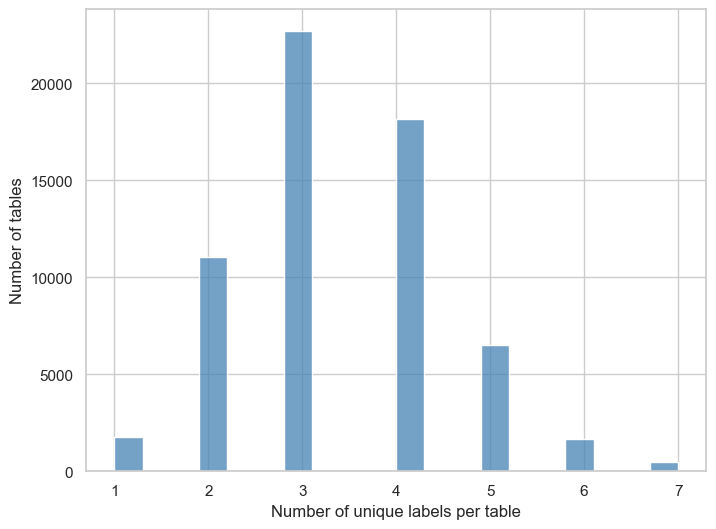

In [10]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set(style="whitegrid")

fig, ax = plt.subplots(1)

sns.histplot(num_unique,kde=False,ax=ax,stat="count",binrange=[1,7], bins=20, color='steelblue')
ax.set(xlabel='Number of unique labels per table', ylabel='Number of tables')
plt.savefig("plots/num_unique_labels_per_table.png")
plt.show()

In [11]:
# Remove tables without any labels
len(empty_tables)

1160

In [12]:
for idx in empty_tables:
    del ner_tables[idx][0]

In [13]:
filtered_tables = [sublist for sublist in ner_tables if len(sublist) > 0]

In [14]:
len(filtered_tables) # after removing 1160 tables which had only 'O' annotation

61273

In [15]:
with open('../data/Wiki_TabNER_final_labeled.json', 'w') as f:
    json.dump(filtered_tables, f)

In [16]:
data_path="../data/Wiki_TabNER_final_labeled.json"

with open(data_path, 'r') as f:
    ner_tables = json.load(f)  
    
print(len(ner_tables))

61273


In [18]:
n_rows=[]
n_columns=[]
n_entities_cell=[]

for i in range(len(ner_tables)):
    table=ner_tables[i]
    cells = table[0][5]
    named_entities =table[0][6] 
    
    n_row = cells[-1][0][0]
    n_col = cells[-1][0][1]    

    n_rows.append(n_row)
    n_columns.append(n_col)
    
    n_entities_cell.append(named_entities)

In [19]:
types_dict={}
for i in range(8):
    types_dict[i]=0

for table in n_entities_cell:
    if table != []:
        for cell in table:
            es=cell[0]            
            for e in es:                
                if e !=[]:
                    types_dict[e[-1]]+=1
print(types_dict)

{0: 1163474, 1: 24840, 2: 430963, 3: 117805, 4: 121829, 5: 686321, 6: 982630, 7: 125261}


In [20]:
del types_dict[0]

In [21]:
labels_dict = {  'Activity': 1,
                 'Organisation': 2,
                 'ArchitecturalStructure': 3,
                 'Event': 4,
                 'Place': 5,
                 'Person': 6,
                 'Work': 7,
                }
labels_dict={v:k for k,v in labels_dict.items()}
print(labels_dict)

{1: 'Activity', 2: 'Organisation', 3: 'ArchitecturalStructure', 4: 'Event', 5: 'Place', 6: 'Person', 7: 'Work'}


In [22]:
labels = [label for label in labels_dict.keys()]
values = [value for value in types_dict.values()]

/var/folders/zs/qtbkgfnj1bd_qhkkmfc294j80000gn/T/ipykernel_53566/4035688165.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=data, palette='Pastel1')


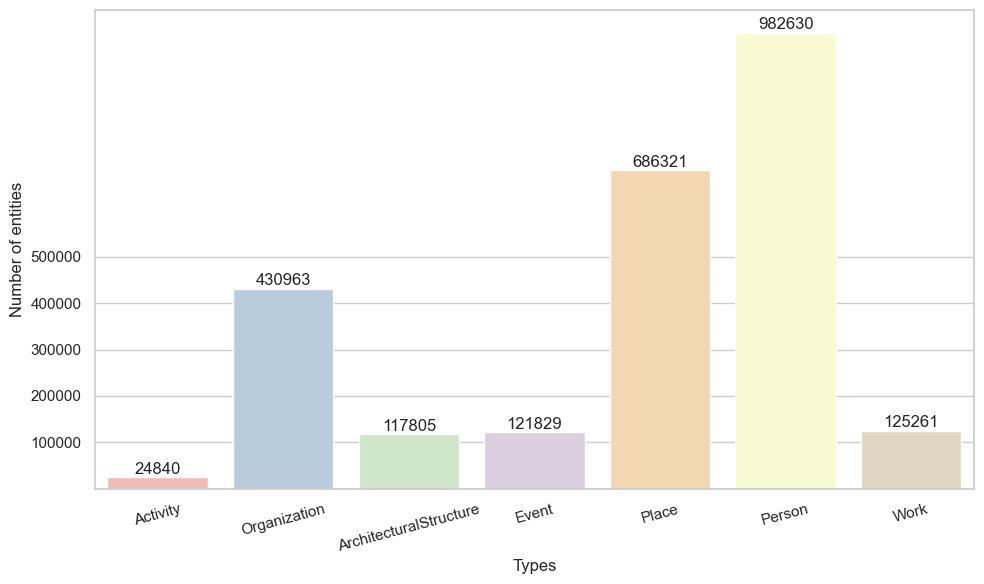

In [23]:
data = [value for value in types_dict.values()]
labels = ['Activity', 'Organization', 'ArchitecturalStructure', 'Event', 'Place', 'Person', 'Work']

# Create a barplot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.barplot(x=labels, y=data, palette='Pastel1')

ax.set_xlabel('Types')
ax.set_ylabel('Number of entities')

for i, v in enumerate(data):
    ax.text(i, v + 1000, str(v), ha='center', va='bottom')
    
plt.yticks([100000, 200000,300000,400000,500000])
plt.xticks(rotation=15)
plt.tight_layout()
#plt.savefig("plots/num_entities_per_type_final.png")
plt.show()

In [24]:
len(n_entities_cell) #num tables

61273

In [25]:
avg_entities_per_cell=[]
sum_entities_per_table=[]

for table in n_entities_cell:
    per_table = 0
    entities_per_cell = []
    
    for cell in table:
        per_cell = 0
        entities = cell[0]
        for e in entities:
            if e[-1] != 0:
                per_cell+=1

        entities_per_cell.append(per_cell)
        per_table += per_cell

    avg_entities_per_cell.append(np.mean(entities_per_cell))
    sum_entities_per_table.append(per_table)

In [26]:
max(sum_entities_per_table)

3228

[Text(0.5, 0, 'Number of labeled entities per table'),
 Text(0, 0.5, 'Number of tables')]

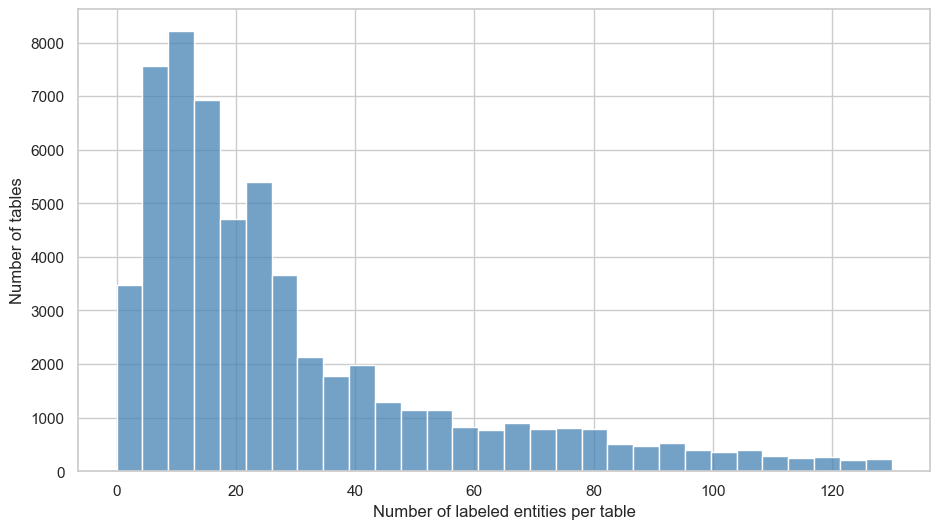

In [34]:
sns.set(rc={'figure.figsize':(11,6)})
sns.set(style="whitegrid")

fig, ax = plt.subplots(1)

sns.histplot(sum_entities_per_table,kde=False,ax=ax,stat="count",binrange=[0,130], bins=30, color='steelblue')
ax.set(xlabel='Number of labeled entities per table', ylabel='Number of tables')
#fig.savefig("plots/ser_entities_per_table.png")

[Text(0.5, 0, 'Number of labeled entities per cell - average per table'),
 Text(0, 0.5, 'Number of tables')]

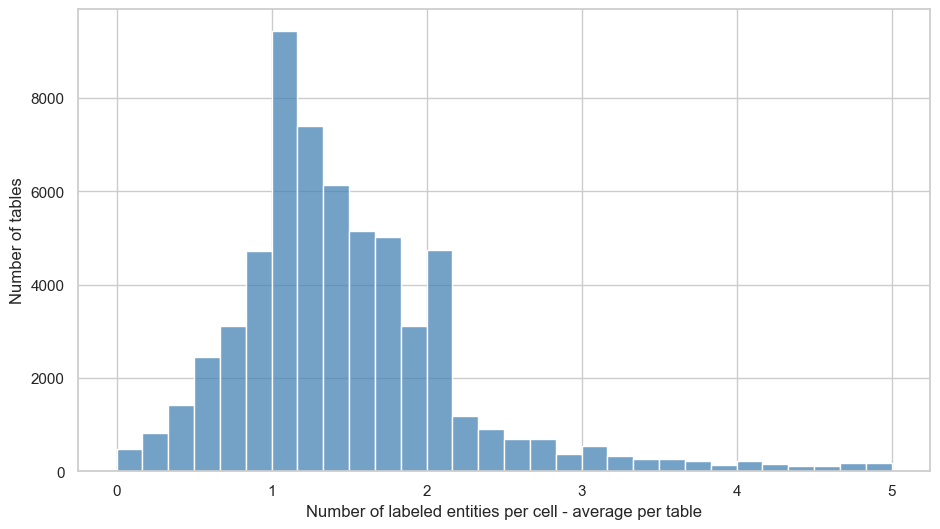

In [35]:
sns.set(rc={'figure.figsize':(11,6)})
sns.set(style="whitegrid")

fig, ax = plt.subplots(1)

sns.histplot(avg_entities_per_cell,kde=False,ax=ax,stat="count",binrange=[0,5],bins=30, color='steelblue')
ax.set(xlabel='Number of labeled entities per cell - average per table', ylabel='Number of tables')

## Test set analysis

In [36]:
len(ner_tables)

61273

In [37]:
seed_nr = 42
generator = torch.Generator().manual_seed(seed_nr)

In [38]:
train_set, test_set = torch.utils.data.random_split(ner_tables, [31273, 30000], generator=generator)

In [39]:
len(test_set)

30000

In [44]:
n_rows=[]
n_columns=[]
n_entities_cell=[]

for i in test_set.indices:
    table=ner_tables[i]
    cells = table[0][5]
    entities =table[0][6] 
       
    
    n_row = cells[-1][0][0]
    n_col = cells[-1][0][1]    

    n_rows.append(n_row)
    n_columns.append(n_col)
    
    n_entities_cell.append(entities)

In [45]:
mean_rows = np.mean(n_rows)
mean_columns =np.mean(n_columns)
print(mean_rows)
print(mean_columns)

11.679833333333333
4.219833333333334


In [46]:
types_dict={}
for i in range(8):
    types_dict[i]=0

for table in n_entities_cell:
    if table != []:
        for cell in table:
            es=cell[0]            
            for e in es:                
                if e !=[]:
                    types_dict[e[-1]]+=1
print(types_dict)

{0: 556757, 1: 11925, 2: 208374, 3: 56431, 4: 59436, 5: 327979, 6: 486606, 7: 62205}


## Plot results

## F1, P and Recall per model

In [183]:
def plot_results(model_name, shot, labels_dict):
    
    file_name = 'results_{}_{}'.format(model_name, shot)   
    data = pd.read_csv(os.path.join('../output/comma_deli', file_name+'.csv'))
    data = data.rename(columns=labels_dict)  
    
   # data = data[data['num_tab']<=550]
    
    # plot overall metrics    
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    plt.plot(data['num_tab'], data['precision'], label='Precision')
    plt.plot(data['num_tab'], data['recall'], label='Recall')
    plt.plot(data['num_tab'], data['f1'], label='F1')
    
    print("precision {}, recall {}, F1 {},".format(data['precision'].mean(), data['recall'].mean(), data['f1'].mean()))

    plt.xlabel('num tables')
    plt.ylabel('Score')
    plt.title('Scores Over num')
    plt.legend() 
    plt.ylim(0, 1)    
    #plt.savefig("../output/plots/"+ "general_"+file_name+".png")
    
    
    # plot Per class
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    plt.plot(data['num_tab'], data['Organisation'], label='Organization')
    plt.plot(data['num_tab'], data['Person'], label='Person')
    plt.plot(data['num_tab'], data['Work'], label='Work')
    plt.plot(data['num_tab'], data['Place'], label='Place')

    plt.xlabel('num tables')
    plt.ylabel('Score')
    plt.title('Scores Over num')
    plt.legend() 
    plt.ylim(0, 1) 

    #plt.savefig("../output/plots/"+ "class_"+file_name+".png")
    
    return data


precision 0.5823107636147439, recall 0.4385023882338703, F1 0.5002360992956759,


0.5002360992956759

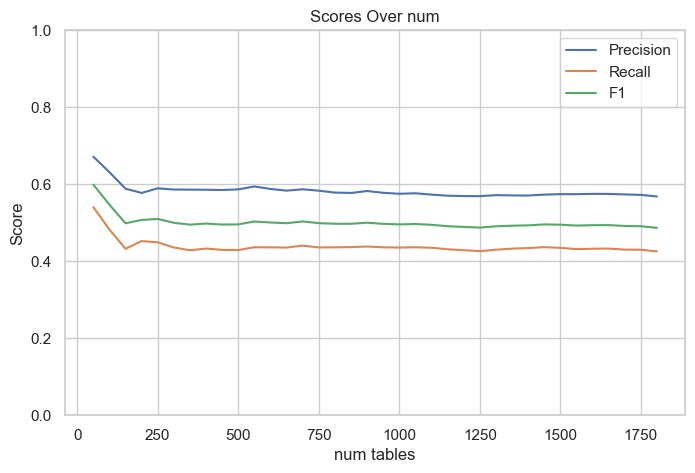

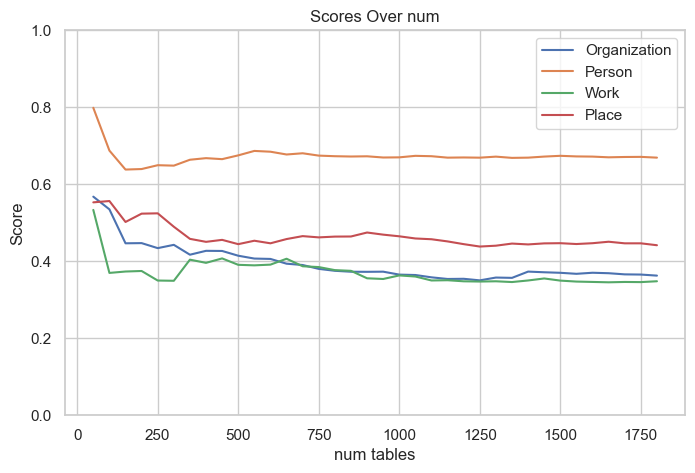

In [185]:
test = plot_results('gpt-35-turbo-instruct', '0', labels_dict)
test["f1"].mean()

In [181]:
def plot_barplot(model_name, shot):
    
    file_name = 'results_{}_{}'.format(model_name, shot)   
    data = pd.read_csv(os.path.join('../output/comma_deli', file_name+'.csv'))
    data = data.rename(columns=labels_dict)
    data.fillna(0, inplace=True)
    
    f1 = []
    classes = ['Activity', 'Organisation', 'ArchitecturalStructure','Event', 'Place', 'Person', 'Work']
    for class_name in classes:
        f1.append(data[class_name].mean())
        
    data_class = { 'Class':classes,'F1 Score':f1, 'reduced':True}
    df = pd.DataFrame(data_class)
    
    plt.figure(figsize=(10, 6))
    palette = 'Pastel1'
    for i, row in df.iterrows():    
        sns.barplot(x='Class', y='F1 Score', hue='Class', data=df, palette=palette)
    # Add labels and title
    sns.set(style="whitegrid")
    plt.xticks(rotation=15)
    plt.ylim(0, 0.9)
    plt.xlabel('Class')
    plt.ylabel('Mean F1 Score')
    #plt.title("{}".format(model_name.upper()))
    plt.title("GPT-3.5-turbo-instruct")
    
    #plt.show()
    save_filename = "class_{}_{}.png".format(model_name.upper(), shot)
    
    return df
    
    #plt.savefig(os.path.join("../output/plots", save_filename))

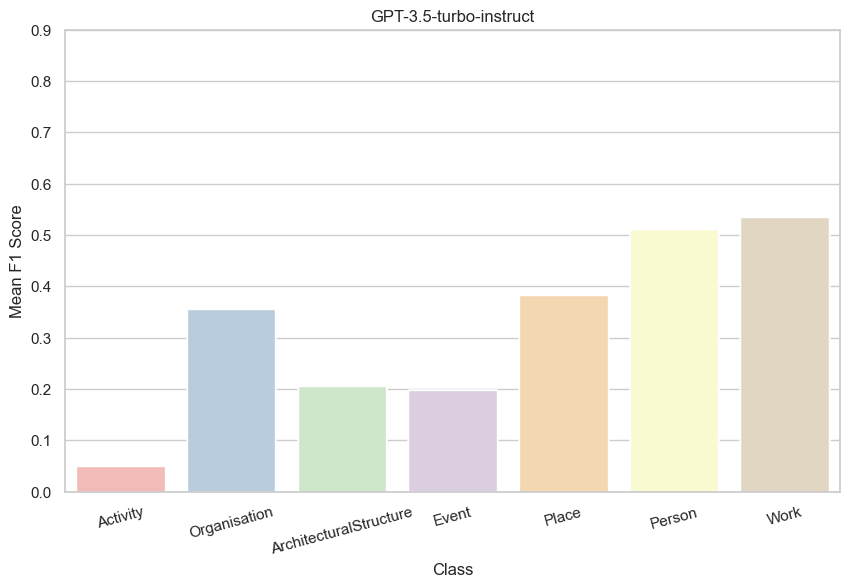

In [182]:
df_gpt_35_0 = plot_barplot("gpt-4",0)

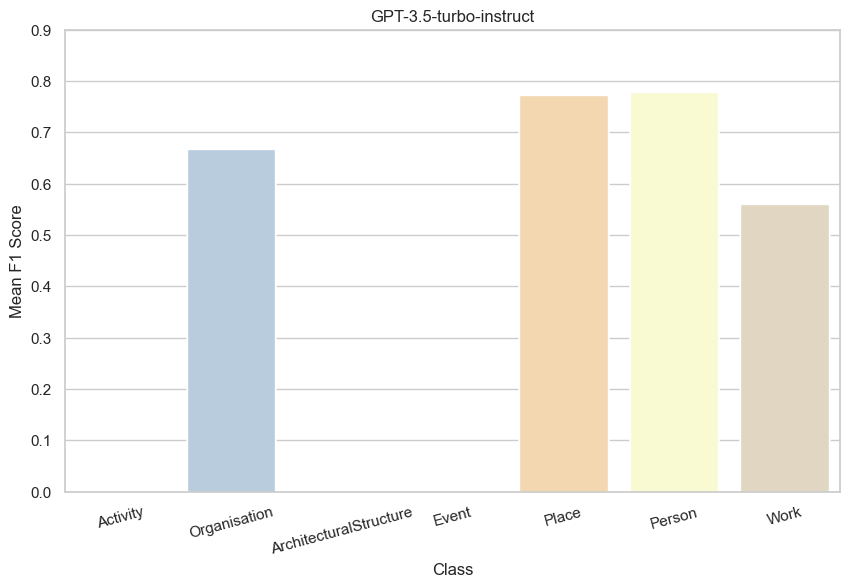

In [176]:
df_gpt_35_3_filtered = plot_barplot("gpt-35-turbo-16k",3)

In [177]:
gpt_inst = pd.concat([df_gpt_35_0,df_gpt_35_3_filtered])

In [ ]:

plt.figure(figsize=(9, 6))
palette = 'muted'

g = sns.catplot(
    data=gpt_inst, kind="bar",
    x='Class', y='F1 Score', hue='reduced',  palette=palette, alpha=.5, height=7.5, dodge=False
)
# Add labels and title
sns.set(style="whitegrid")
plt.xticks(rotation=15)
plt.ylim(0, 0.9)
plt.xlabel('Class', fontsize=16)
plt.ylabel('Mean F1 Score', fontsize=16)
plt.title("GPT-3.5-turbo")

#plt.savefig(os.path.join("../output/plots", "GPT-35-turbo-instruct_both.png"), bbox_inches = "tight")

### LLama per class bar plot - results are taken from the Llama_model notebook

In [80]:
llama2_3shot_sim= {5: 0.41476424151909536, 1: 0.22614840989399287, 6: 0.3753812032159689, 7: 0.14384508990318118, 2: 0.3681090693538826, 3: 0.28609625668449196, 4: 0.3216374269005848}
llama2_0shot_sim= {6: 0.03505911129229515, 2: 0.014369106421194431, 3: 0.0036968576709796677, 7: 0.003273322422258592, 5: 0.0006795786612300373}

In [95]:
df0 = pd.DataFrame(list(labels_dict.items()), columns=['Label', 'Class'])
df0['F1 Score'] = df0['Label'].astype(int).map(llama2_0shot_sim)
df0['k-shot'] = 0

In [96]:
df3 = pd.DataFrame(list(labels_dict.items()), columns=['Label', 'Class'])
df3['F1 Score'] = df3['Label'].astype(int).map(llama2_3shot_sim)
df3['k-shot'] = 3

In [108]:
df = pd.concat([df0, df3])
df.fillna(0, inplace=True)

In [103]:
del df['Label']

In [109]:
df

,Label,Class,F1 Score,k-shot
0,1,Activity,0.000000,0
1,2,Organisation,0.014369,0
2,3,ArchitecturalStructure,0.003697,0
3,4,Event,0.000000,0
4,5,Place,0.000680,0
5,6,Person,0.035059,0
6,7,Work,0.003273,0
0,1,Activity,0.226148,3
1,2,Organisation,0.368109,3
2,3,ArchitecturalStructure,0.286096,3


<Figure size 900x600 with 0 Axes>

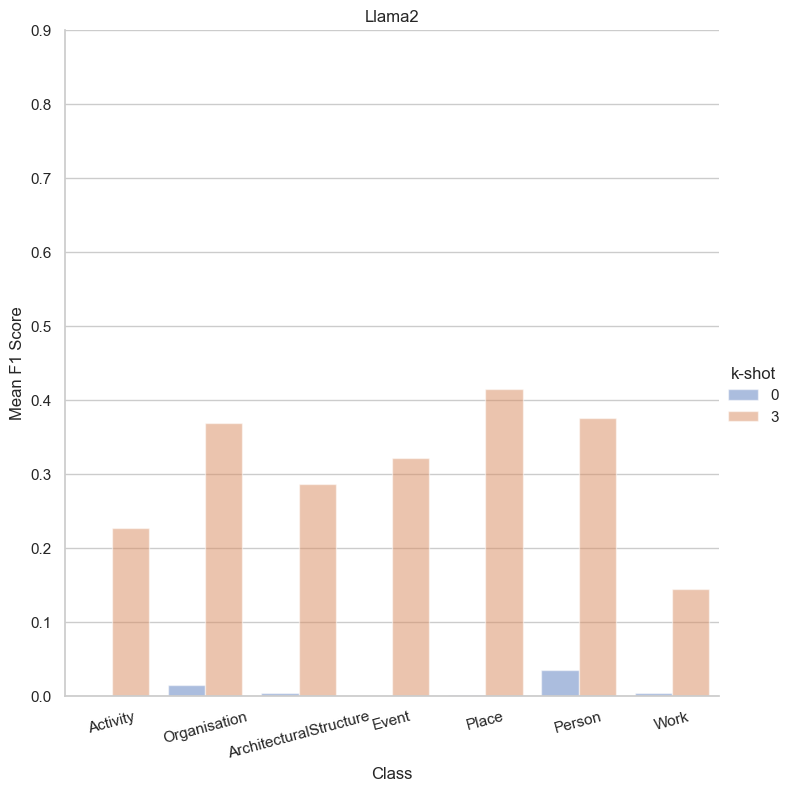

In [113]:
plt.figure(figsize=(9, 6))
palette = 'muted'

g = sns.catplot(
    data=df, kind="bar",
    x='Class', y='F1 Score', hue='k-shot',  palette=palette, alpha=.5, height=7.5, dodge=True
)
# Add labels and title
sns.set(style="whitegrid")
plt.xticks(rotation=15)
plt.ylim(0, 0.9)
plt.xlabel('Class')
plt.ylabel('Mean F1 Score')
plt.title("Llama2")

plt.savefig(os.path.join("../output/plots", "Llama2_both.png"), bbox_inches = "tight")